# New architecture with best attribute of NASNET with spatial and self attention

Last modified: 7-03-2023

In [1]:
! git clone https://github.com/nisarahmedrana/BIQ2021.git

Cloning into 'BIQ2021'...
remote: Enumerating objects: 12084, done.
remote: Total 12084 (delta 0), reused 0 (delta 0), pack-reused 12084
Receiving objects: 100% (12084/12084), 803.80 MiB | 27.03 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (12006/12006), done.


In [33]:
import shutil
shutil.rmtree('/notebooks/BIQ2021')

In [1]:
%cd /notebooks/BIQ2021/

/notebooks/BIQ2021


In [6]:
import shutil
import os
    
source_dir = '/notebooks/BIQ2021/Subset_01'
target_dir = '/notebooks/BIQ2021/BIQ_Dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Concatenate,Flatten, GlobalAveragePooling2D,BatchNormalization, Multiply,Dropout, Reshape, Add, LSTM,Multiply
from tensorflow.keras.applications import InceptionResNetV2, ResNet50,EfficientNetB7



# Function to create spatial attention layer
def spatial_attention(x):
    avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    conv = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(concat)
    output = Multiply()([x, conv])
    return output


# Function to create channel attention layer
def channel_attention(x):
    avg_pool = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    max_pool = tf.reduce_max(x, axis=(1, 2), keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    dense1 = Dense(units=x.shape[-1] // 8, activation='relu')(concat)
    dense2 = Dense(units=x.shape[-1], activation='sigmoid')(dense1)
    output = Multiply()([x, dense2])
    return output

def model_qa(num_classes,input_shape):
    
    
    
    # Create input layers for the backbone networks
    
    input_layer=Input(shape=input_shape)
    

    base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape,input_tensor=input_layer)
    x2 = base_model2.output
    x2= tf.keras.layers.GlobalAveragePooling2D()(x2)
    x2 =  Reshape((1, 1, -1))(x2)
    x2 = spatial_attention(x2)
    x2= channel_attention(x2)
    x2=Flatten()(x2)
 
    
    base_model3 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape,input_tensor=input_layer)
    x3 = base_model3.output
    x3= tf.keras.layers.GlobalAveragePooling2D()(x3)
    x3 =  Reshape((1, 1, -1))(x3)
    x3 = spatial_attention(x3)
    x3= channel_attention(x3)
    x3=Flatten()(x3)
    
    
    
    concatenated_output = Concatenate()([x2,x3])
    

    x = Dense(1024, activation='relu')(concatenated_output)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Define the regression head
    
    predictions = Dense(num_classes, activation='linear')(x)
    model = Model(inputs=input_layer, outputs=predictions)
    return model

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import tensorflow as tf


# Define the image dimensions and other hyperparameters
img_width, img_height = 224, 224
batch_size = 16
num_epochs = 100

# Load the KonIQ-10k Train dataset
train_df = pd.read_csv('/notebooks/BIQ2021/Train (Images and MOS).csv')

# Load the KonIQ-10k Train dataset
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.2
    
)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory='/notebooks/BIQ2021/Images',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='raw',
                                                    x_col='Image Name',
                                                    y_col='MOS',
                                                    subset='training',
                                                    shuffle=True)
# Load the KonIQ-10k Val dataset
val_generator = train_datagen.flow_from_dataframe(train_df,
                                                directory='/notebooks/BIQ2021/Images',
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='raw',
                                                x_col='Image Name',
                                                y_col='MOS',
                                                subset='validation',
                                                shuffle=True)

# Load the KonIQ-10k Val dataset
test_df = pd.read_csv('/notebooks/BIQ2021/Test (Images and MOS).csv')
test_datagen = ImageDataGenerator(rescale=1./255,
                                 samplewise_center=True,
                                 samplewise_std_normalization=True)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                directory='/notebooks/BIQ2021/Images',
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='raw',
                                                x_col='Image Name',
                                                y_col='MOS',
                                                shuffle=False)


# Define the input layer for the model
input_shape = (img_width, img_height, 3)

Found 8000 validated image filenames.
Found 1999 validated image filenames.
Found 2000 validated image filenames.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="Image Name". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [3]:
import tensorflow as tf

def koniq_combined_loss(y_true, y_pred):
    
    # Calculate mean absolute error (MAE) between true and predicted scores
    mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

#     # Calculate mean of true and predicted scores
    mean_true = tf.reduce_mean(y_true)
    mean_pred = tf.reduce_mean(y_pred)

    # Calculate standard deviation of true and predicted scores
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)

    # Calculate covariance of true and predicted scores
    covariance = tf.reduce_mean((y_true - mean_true) * (y_pred - mean_pred))

    # Calculate PLCC
    plcc = covariance / (std_true * std_pred)
   
    # Convert PLCC to a loss value
    plcc_loss = 1 - plcc

    # Combine MAE and PLCC losses
    combined_loss=10*mae_loss+10*plcc_loss
    

    return combined_loss

In [4]:
def plcc_train(y_true, y_pred):
     # Calculate mean of true and predicted scores
    mean_true = tf.reduce_mean(y_true)
    mean_pred = tf.reduce_mean(y_pred)

    # Calculate standard deviation of true and predicted scores
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)

    # Calculate covariance of true and predicted scores
    covariance = tf.reduce_mean((y_true - mean_true) * (y_pred - mean_pred))

    # Calculate PLCC
    plcc = covariance / (std_true * std_pred)
    return plcc

In [8]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, Nadam,RMSprop

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/notebooks/IQA/model-koniq/BIQ2021_Final_BO_next.h5',monitor='val_plcc_train', 
                                                         save_best_only=True, mode='max',patience=10, verbose=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_plcc_train', mode='max', patience=50, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, min_lr=1e-12)
# Create a CSVLogger callback to save the logs to a file
log_file_path = os.path.join('/notebooks/IQA/log_dir-koniq/', 'BIQ2021_BO_next.csv')
csv_logger = CSVLogger(log_file_path)
# Compile the model with the mean squared error loss and the Adam optimizer
model=model_qa(num_classes=1,input_shape=input_shape)
# Set hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 1e-4

# # Compile model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=koniq_combined_loss, metrics=['mae',plcc_train])

258076736/258076736 [==============================] - 2s 0us/step


In [ ]:
# Train the model on the training set
history=model.fit(train_generator,
          epochs=num_epochs,
          validation_data=val_generator,
          callbacks=[checkpoint_callback, early_stopping_callback,csv_logger,reduce_lr])

Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 22.6023 - mae: 1.5220 - plcc_train: 0.2617
Epoch 1: val_plcc_train improved from -inf to 0.30217, saving model to /notebooks/IQA/model-koniq/BIQ2021_Final_BO_next.h5
500/500 [==============================] - 608s 1s/step - loss: 22.6023 - mae: 1.5220 - plcc_train: 0.2617 - val_loss: 9.6526 - val_mae: 0.2674 - val_plcc_train: 0.3022 - lr: 1.0000e-04
Epoch 2/200
500/500 [==============================] - ETA: 0s - loss: 19.1415 - mae: 1.2537 - plcc_train: 0.3395
Epoch 2: val_plcc_train improved from 0.30217 to 0.57413, saving model to /notebooks/IQA/model-koniq/BIQ2021_Final_BO_next.h5
500/500 [==============================] - 558s 1s/step - loss: 19.1415 - mae: 1.2537 - plcc_train: 0.3395 - val_loss: 9.4158 - val_mae: 0.5158 - val_plcc_train: 0.5741 - lr: 1.0000e-04
Epoch 3/200
500/500 [==============================] - ETA: 0s - loss: 16.9203 - mae: 1.0620 - plcc_train: 0.3700
Epoch 3: val_plcc_train improved from

--------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------


In [53]:
import os
train_dir='/notebooks/LIVEC/ChallengeDB_release/Images/'
abs_file_names = []
test_df = pd.read_csv('/notebooks/LIVEC/LIVEC.csv',names=['image_name', 'MOS'])

for file_name in test_df['image_name']:
    tmp = os.path.abspath(train_dir+file_name)
    abs_file_names.append(tmp)

# update dataframe
test_df['Image_name'] = abs_file_names

In [54]:
test_df

,image_name,MOS,Image_name
0,t1.bmp,63.963406,/notebooks/LIVEC/ChallengeDB_release/Images/t1...
1,t2.bmp,25.335306,/notebooks/LIVEC/ChallengeDB_release/Images/t2...
2,t3.bmp,48.936563,/notebooks/LIVEC/ChallengeDB_release/Images/t3...
3,t4.bmp,35.886332,/notebooks/LIVEC/ChallengeDB_release/Images/t4...
4,t5.bmp,66.509237,/notebooks/LIVEC/ChallengeDB_release/Images/t5...
...,...,...,...
1164,1160.bmp,21.685859,/notebooks/LIVEC/ChallengeDB_release/Images/11...
1165,1161.bmp,11.900285,/notebooks/LIVEC/ChallengeDB_release/Images/11...
1166,1162.bmp,62.661712,/notebooks/LIVEC/ChallengeDB_release/Images/11...
1167,1163.bmp,87.065592,/notebooks/LIVEC/ChallengeDB_release/Images/11...


In [27]:
data=test_df
data = data.sample(frac=1).reset_index(drop=True)
from sklearn.model_selection import train_test_split

train, test_val = train_test_split(data, test_size=0.3, random_state=42)
test, val = train_test_split(test_val, test_size=0.5, random_state=42)

train.to_csv('/notebooks/storage/tid2013/tid2013train.csv', index=False)
test.to_csv('/notebooks/storage/tid2013/tid2013test.csv', index=False)
val.to_csv('/notebooks/storage/tid2013/tid2013val.csv', index=False)


In [55]:
# Define the image dimensions and other hyperparameters
img_width, img_height = 224, 224
batch_size = 5

# Load the TID2013 dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                    train_dir=None,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='raw',
                                                    x_col='Image_name',
                                                    y_col='MOS',
                                                    shuffle=False,
                                                    seed=0
                                                    )

Found 1169 validated image filenames.


#Retraning

In [5]:
import csv
import os
import numpy as np
import tensorflow as tf
new_model = tf.keras.models.load_model('/notebooks/IQA/model-koniq/BIQA-after-28.h5',custom_objects={"plcc_train": plcc_train,"koniq_combined_loss":koniq_combined_loss})

In [12]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import CSVLogger,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/notebooks/IQA/model-koniq/BIQA-after-28.h5', monitor='val_mae', save_best_only=True,patience=15)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15)
# Create a CSVLogger callback to save the logs to a file
log_file_path = os.path.join('/notebooks/IQA/log_dir-koniq/', 'BIQA_after-28.csv')
csv_logger = CSVLogger(log_file_path)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)

# Set hyperparameters
batch_size = 10
num_epochs = 32
learning_rate = 1e-6

In [13]:
# Train the model on the training set
history=new_model.fit(train_generator,
          epochs=num_epochs,
          validation_data=val_generator,
          callbacks=[checkpoint_callback, earlystop_callback,csv_logger,reduce_lr])

Epoch 1/32


2023-04-05 12:57:00.836611: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-05 12:57:00.836676: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-05 12:57:00.843410: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-05 12:57:00.843464: W tensorflow/core/common_runtime/bfc_allocato

500/500 [==============================] - ETA: 0s - loss: 1.8959 - mae: 0.0964 - plcc_train: 0.9068

2023-04-05 13:02:44.280578: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-05 13:02:44.280647: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-05 13:02:44.380031: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-05 13:02:44.380094: W tensorflow/core/common_runtime/bfc_allocato

500/500 [==============================] - 370s 692ms/step - loss: 1.8959 - mae: 0.0964 - plcc_train: 0.9068 - val_loss: 2.6979 - val_mae: 0.0972 - val_plcc_train: 0.8274 - lr: 1.0000e-04
Epoch 2/32
500/500 [==============================] - 339s 678ms/step - loss: 1.6375 - mae: 0.0858 - plcc_train: 0.9220 - val_loss: 2.2847 - val_mae: 0.0733 - val_plcc_train: 0.8448 - lr: 1.0000e-04
Epoch 3/32
500/500 [==============================] - 337s 673ms/step - loss: 1.4176 - mae: 0.0771 - plcc_train: 0.9353 - val_loss: 2.3935 - val_mae: 0.0845 - val_plcc_train: 0.8452 - lr: 1.0000e-04
Epoch 4/32
500/500 [==============================] - 340s 679ms/step - loss: 1.2786 - mae: 0.0705 - plcc_train: 0.9427 - val_loss: 2.2737 - val_mae: 0.0731 - val_plcc_train: 0.8457 - lr: 1.0000e-04
Epoch 5/32
500/500 [==============================] - 337s 673ms/step - loss: 1.1385 - mae: 0.0650 - plcc_train: 0.9512 - val_loss: 2.4706 - val_mae: 0.0816 - val_plcc_train: 0.8346 - lr: 1.0000e-04
Epoch 6/32
500/5

In [5]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/notebooks/IQA/model-koniq/BIQ2021_Final_BO_next.h5',custom_objects={'koniq_combined_loss':koniq_combined_loss,'plcc_train':plcc_train})

In [ ]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, Nadam

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/notebooks/IQA/model-koniq/NAS_model_koniq_next.h5',monitor='val_mae', 
                                                         save_best_only=True, mode='min',patience=10, verbose=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Create a CSVLogger callback to save the logs to a file
log_file_path = os.path.join('/notebooks/IQA/log_dir-koniq/', 'KonIQ_log_next.csv')
csv_logger = CSVLogger(log_file_path)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)
# Set hyperparameters
batch_size = 20
num_epochs = 40
learning_rate = 1e-4


In [ ]:
# Train the model on the training set
history=new_model.fit(train_generator,
          epochs=num_epochs,
          validation_data=val_generator,
          callbacks=[checkpoint_callback, early_stopping_callback,csv_logger,reduce_lr])

Epoch 1/40
442/442 [==============================] - ETA: 0s - loss: 13.2301 - mae: 9.7062 - plcc_train: 0.6483
Epoch 1: val_mae improved from inf to 7.81712, saving model to /notebooks/IQA/model-koniq/NAS_model_koniq_next.h5
442/442 [==============================] - 133s 291ms/step - loss: 13.2301 - mae: 9.7062 - plcc_train: 0.6483 - val_loss: 10.5207 - val_mae: 7.8171 - val_plcc_train: 0.7300 - lr: 1.0000e-04
Epoch 2/40
 64/442 [===>..........................] - ETA: 1:42 - loss: 12.9778 - mae: 9.6873 - plcc_train: 0.6710

In [9]:
Y_pred=new_model.predict(test_generator)

125/125 [==============================] - 17s 136ms/step


In [11]:
Y_pred=np.array(y_pred.ravel())
Y_test=np.array(test_generator.labels)

In [9]:
data_pred={'Y_pred':Y_pred,'Y_test':Y_test}
df=pd.DataFrame(data_pred)

In [8]:
df.to_csv('LIVEC-out.csv', index=False)

In [12]:
import scipy
import matplotlib.pyplot as plt
def srocc(xs, ys):
    """Spearman Rank Order Correlation Coefficient"""
    xranks = pd.Series(xs).rank()    
    yranks = pd.Series(ys).rank()    
    return plcc(xranks, yranks)

def dist2mos(x, scale=np.arange(1, 6)):
    """
    Find the MOS of a distribution of scores `x`, given a `scale`.
    e.g. x=[0,2,2], scale=[1,2,3] => MOS=2.5
    """
    x = x / np.reshape(np.sum(x*1., axis=1), (len(x), 1))
    return np.sum(x * scale, axis=1)
def plcc(y_true, y_pred):
    """Pearson Linear Correlation Coefficient"""
    return scipy.stats.pearsonr(y_true, y_pred)[0]
def krcc(x, y):
    return scipy.stats.kendalltau(x, y)[0]

In [12]:
def rating_metrics(y_true, y_pred, show_plot=True):    
    """
    Print out performance measures given ground-truth (`y_true`) and predicted (`y_pred`) scalar arrays.
    """
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    p_plcc = np.round(plcc(y_true, y_pred),3)
    p_srcc = np.round(srocc(y_true, y_pred),3)
    p_mae  = np.round(np.mean(np.abs(y_true - y_pred)),3)
    p_rmse  = np.round(np.sqrt(np.mean((y_true - y_pred)**2)),3)
    
    if show_plot:
        print('SRCC: {} | PLCC: {} | MAE: {} | RMSE: {}'.\
              format(p_srcc, p_plcc, p_mae, p_rmse))    
        plt.plot(y_true, y_pred,'.',markersize=1)
        plt.xlabel('ground-truth')
        plt.ylabel('predicted')
        plt.show()
    return (p_srcc, p_plcc, p_mae, p_rmse)

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



sns.set(font='DejaVu Serif',style="white")
font = {'family': 'DejaVu Serif', 'size': 10}
def rating_metrics(y_true, y_pred, show_plot=True):    
    """
    Print out performance measures given ground-truth (`y_true`) and predicted (`y_pred`) scalar arrays.
    """
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    p_plcc = np.round(plcc(y_true, y_pred),3)
    p_srcc = np.round(srocc(y_true, y_pred),3)
    p_krcc=  np.round(krcc(y_true, y_pred),3)

    p_mae  = np.round(np.mean(np.abs(y_true - y_pred)),3)
    p_rmse  = np.round(np.sqrt(np.mean((y_true - y_pred)**2)),3)
    
    if show_plot:
        print('SRCC: {} | PLCC: {} | KRCC: {} | MAE: {} | RMSE: {}'.\
              format(p_srcc, p_plcc,p_krcc, p_mae, p_rmse))  
        data = pd.DataFrame({'Y_test': y_true, 'Y_pred': y_pred})
        # Create scatter plot with lines of best fit
        sns.lmplot(x='Y_pred', y='Y_test',data=data, scatter_kws={'s': 1,'marker': '+'}, height=3.4,ci=95, line_kws={'label': 'Predicted Line'})
        sns.lineplot(x='Y_test', y='Y_test',data=data,color='red',label='Traget Line',linestyle=':')
        # Add labels and title
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
         
        # Set figure size and resolution
        plt.gcf().set_size_inches(3.4, 3.4)
        plt.gcf().dpi = 120

        plt.legend(loc='upper right', bbox_to_anchor=(0.65, 1),prop=font)
        # Save plot as PNG image
        plt.savefig('/notebooks/koniq/KONIQ10k_plot.png', dpi=1200, bbox_inches='tight')

        # Show plot (optional)
        plt.show()
    return (p_srcc, p_plcc, p_mae, p_rmse)

/tmp/ipykernel_582/2704820215.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_pred, shade=True, label='y_pred')
/tmp/ipykernel_582/2704820215.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_test, shade=True, label='y_true')


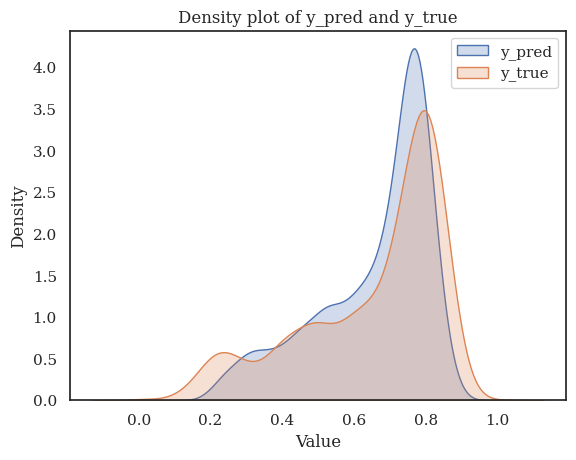

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font='DejaVu Serif',style="white")
font = {'family': 'DejaVu Serif', 'size': 10}
# Create a KDE plot of y_pred
sns.kdeplot(Y_pred, shade=True, label='y_pred')

# Create a KDE plot of y_true
sns.kdeplot(Y_test, shade=True, label='y_true')

# Add legend
plt.legend(loc='upper right')

# Add axis labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density plot of y_pred and y_true')
# Save plot as PNG image
plt.savefig('/notebooks/koniq/BIQA_dist.png', dpi=1200, bbox_inches='tight')
# Show the plot
plt.show()

## Train on BIQ2021 tested on BIQ2021


SRCC: 0.856 | PLCC: 0.851 | MAE: 0.072 | RMSE: 0.103


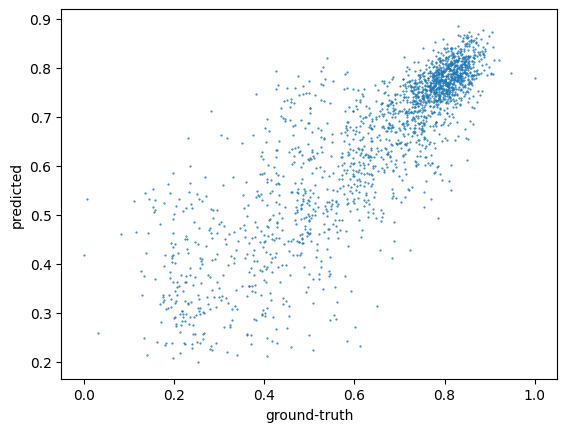

In [13]:
(p_srcc, p_plcc, p_mae, p_rmse)=rating_metrics(Y_test,Y_pred)

SRCC: 0.856 | PLCC: 0.851 | KRCC: 0.665 | MAE: 0.072 | RMSE: 0.103


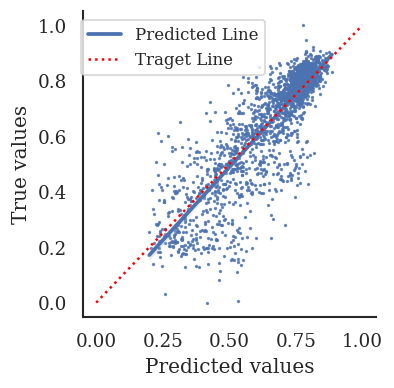

In [14]:
(p_srcc, p_plcc, p_mae, p_rmse)=rating_metrics(Y_test,Y_pred)